In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import random
words = open('cleanednames.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
dataSetCount = len(words)

In [4]:
dataSetItemMax = max(len(w) for w in words)

In [5]:
N = torch.zeros((27,27), dtype=torch.int32)

In [6]:
chars = sorted(list(set(''.join(words))))
stoj = {i:j+1 for j,i in enumerate(chars)}
stoj['.'] = 0
jots = {j:i for i,j in stoj.items()}

In [7]:
#adding the counts for every bigram in the data set to tensor N
for w in words:
    bucket = ['.'] + list(w) + ['.']
    for i in range(len(bucket)-1):
        jx1, jx2 = stoj[bucket[i]], stoj[bucket[i+1]]
        N[jx1, jx2] += 1

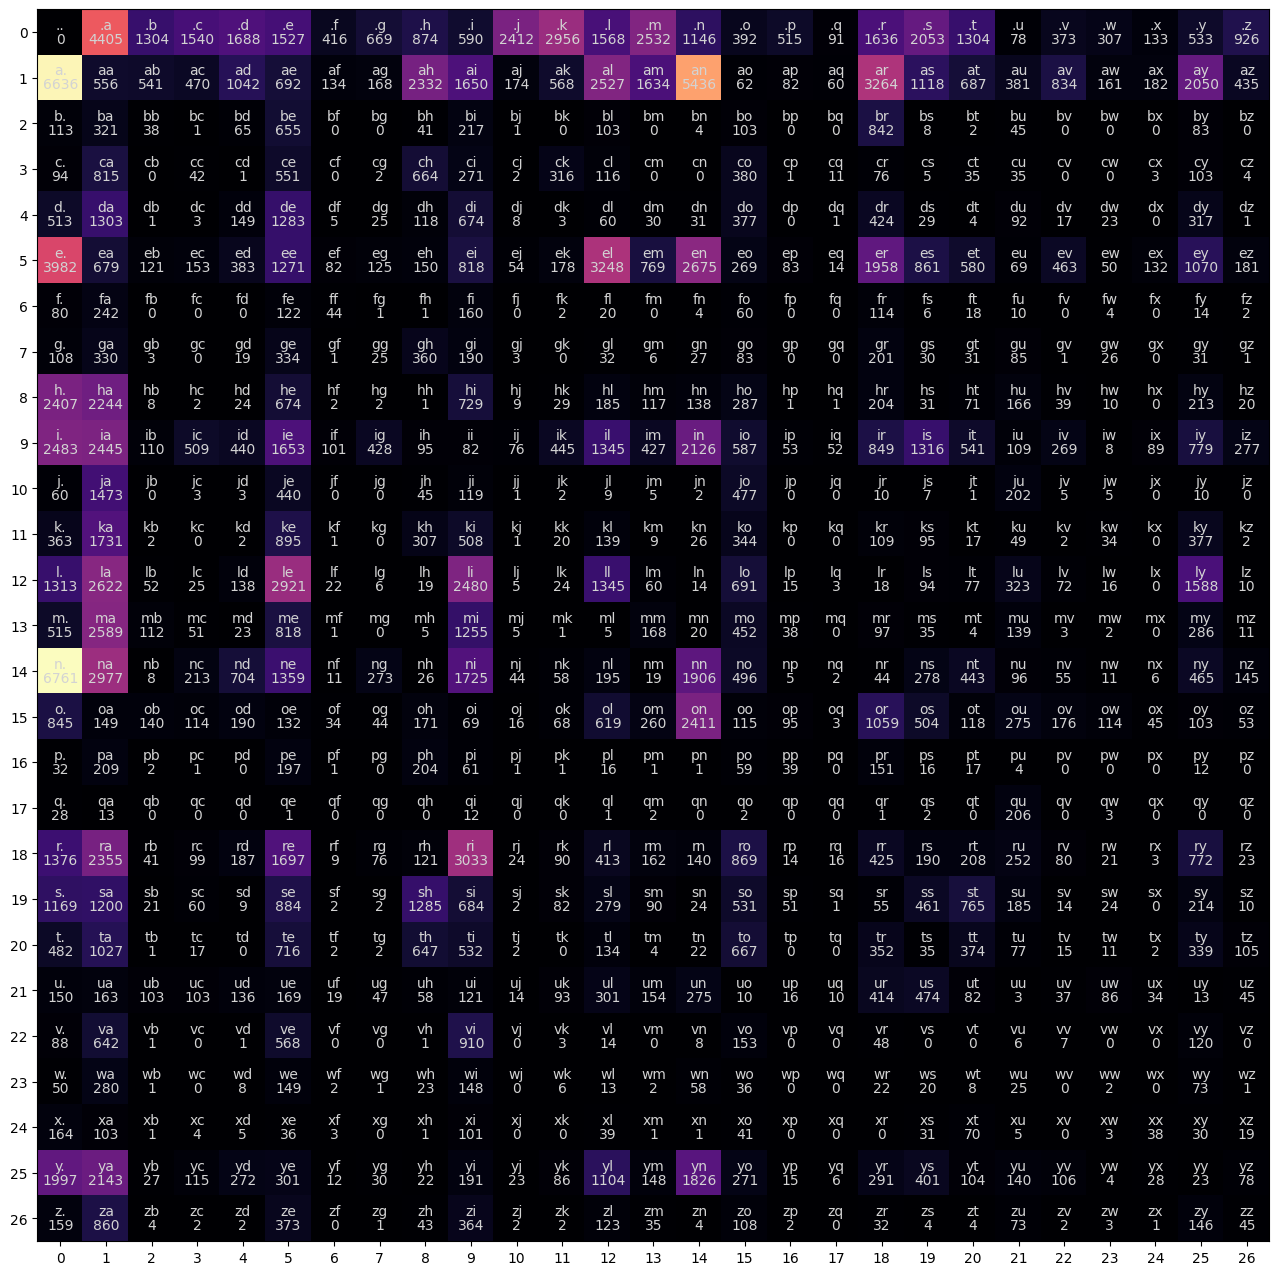

In [8]:
#visualizing the full tensor and each bigram count
plt.figure(figsize=(16,16))
plt.xticks(range(27))
plt.yticks(range(27))
plt.imshow(N, cmap='magma')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1]) #flipping axis for chart clarity, although it no longer reflects the tensor's structure
for i in range(27):
    for j in range(27):
        chtostr = jots[i] + jots[j]
        plt.text(j, i, chtostr, ha='center', va='bottom', color='lightgrey')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='lightgrey')

In [9]:
#example probability distribution of bigrams
p = N[0].float()
p /= sum(p)
p

tensor([0.0000, 0.1378, 0.0408, 0.0482, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0185, 0.0755, 0.0925, 0.0490, 0.0792, 0.0358, 0.0123, 0.0161, 0.0028,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [10]:
sample = torch.multinomial(p, num_samples=1, replacement=True).item()
sample

10

In [11]:
PM = (N+1).float() #ProbabilityMatrix
PM = PM / PM.sum(1, keepdim=True)

In [12]:
#generates novel name combinations
rand21 = torch.Generator().manual_seed(2147483647)
count = 0
while count < 5:
    index = 0
    output = []
    while True:
        p = PM[index]
        index = torch.multinomial(p, num_samples=1, replacement=True, generator=rand21).item()
        output.append(jots[index])
        if index == 0:
            break
    if len(output) <= 3 or len(output) >= 13:
        continue
    count += 1
    print(''.join(output).strip('.').capitalize())

Junide
Janasah
Cony
Kohin
Tolian


In [13]:
#evaluating the overall quality of the model
totalLogLikelihood = 0.0
mostFitName = 'str'
leastFitName = 'str'
maximaLikelihood = 1 #Keep in mind, a lower log likelihood indicates higher fitness, the maxima Likelihood is the least likely spelling
minimaLikelihood = 10
n = 0

print('Example first word:')
for w in words:
    bucket = ['.'] + list(w) + ['.']
    wordLikelihood = 0
    for i in range(len(bucket)-1):
        jx1, jx2 = stoj[bucket[i]], stoj[bucket[i+1]]
        probability = PM[jx1,jx2].item()
        bigramLikelihood = torch.log(PM[jx1,jx2])
        totalLogLikelihood -= bigramLikelihood
        wordLikelihood -= bigramLikelihood.item()
        n += 1
        if n < 5:
            print(f'{bucket[i]}{bucket[i+1]} -> {round((probability*100),1):4}%  Likelihood of bigram: {round(bigramLikelihood.item(),3)}')
    if (wordLikelihood/(len(bucket)-1)) < minimaLikelihood:
        minimaLikelihood = (wordLikelihood/(len(bucket)-1))
        mostFitName = ''.join(bucket)
    elif (wordLikelihood/(len(bucket)-1)) > maximaLikelihood:
        maximaLikelihood = (wordLikelihood/(len(bucket)-1))
        leastFitName = ''.join(bucket)
print(f'Most likely name spelling: {mostFitName.strip(".").capitalize()}     Normalized Log Likelihood: {minimaLikelihood:.4f}')
print(f'Least likely name spelling: {leastFitName.strip(".").capitalize()}   Normalized Log Likelihood: {maximaLikelihood:.4f}')
print(f'Normalized loglikelihood of entire dataset: {totalLogLikelihood/n:.5f}')

Example first word:
.e ->  4.8%  Likelihood of bigram: -3.042
em ->  3.8%  Likelihood of bigram: -3.279
mm ->  2.5%  Likelihood of bigram: -3.674
ma -> 38.9%  Likelihood of bigram: -0.945
Most likely name spelling: Jan     Normalized Log Likelihood: 1.5231
Least likely name spelling: Hajj   Normalized Log Likelihood: 4.2471
Normalized loglikelihood of entire dataset: 2.45367


In [67]:
#alternative probability model implemented with a neural net
xs, ys = [], []
for w in words[:1]:
    bucket = ['.'] + list(w) + ['.']
    for i in range(len(bucket)-1):
        jx1, jx2 = stoj[bucket[i]], stoj[bucket[i+1]]
        xs.append(jx1)
        ys.append(jx2) 
xs, ys = torch.tensor(xs), torch.tensor(ys)

torch.Size([5])

In [68]:
nlls = torch.zeros(5)
xhot = torch.nn.functional.one_hot(xs, num_classes=27).float()
weight = torch.randn((27,27),generator=torch.Generator().manual_seed(2147483648))
logits = xhot @ weight
probability = logits.exp() / logits.exp().sum(1, keepdims=True) #softmax function
for i in range(5):
    p = probability[i,ys[i].item()]
    nll = -1*torch.log(p)
    nlls[i] = nll
    print(f'{jots.get(xs[i].item())} {xs[i]=}{p=} {nll=}')
print(f'Normalized negative log likelihood (loss function)= {nlls.mean().item()}')
#TODO implement gradient-based optimization to minimize loss function

torch.Size([5, 27])
torch.Size([5, 27])
. xs[i]=tensor(0)p=tensor(0.0573) nll=tensor(2.8587)
e xs[i]=tensor(5)p=tensor(0.0146) nll=tensor(4.2275)
m xs[i]=tensor(13)p=tensor(0.0321) nll=tensor(3.4399)
m xs[i]=tensor(13)p=tensor(0.0235) nll=tensor(3.7513)
a xs[i]=tensor(1)p=tensor(0.0737) nll=tensor(2.6081)
Normalized negative log likelihood (loss function)= 3.3770878314971924
